In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def bd_rate(r1, psnr1, r2, psnr2, name1=None, name2=None):
    """ Compute average bit rate saving of RD-2 over RD-1.

    Equivalent to the implementations in:
    https://github.com/Anserw/Bjontegaard_metric/blob/master/bjontegaard_metric.py
    https://github.com/google/compare-codecs/blob/master/lib/visual_metrics.py
    """
    lr1 = np.log(r1)
    lr2 = np.log(r2)

    # fit each curve by a polynomial
    degree = 3
    p1 = np.polyfit(psnr1, lr1, deg=degree)
    p2 = np.polyfit(psnr2, lr2, deg=degree)
    # compute integral of the polynomial
    p_int1 = np.polyint(p1)
    p_int2 = np.polyint(p2)
    # area under the curve = integral(max) - integral(min)
    min_psnr = max(min(psnr1), min(psnr2))
    max_psnr = min(max(psnr1), max(psnr2))
    auc1 = np.polyval(p_int1, max_psnr) - np.polyval(p_int1, min_psnr)
    auc2 = np.polyval(p_int2, max_psnr) - np.polyval(p_int2, min_psnr)

    # find avgerage difference
    avg_exp_diff = (auc2 - auc1) / (max_psnr - min_psnr)
    avg_diff = (np.exp(avg_exp_diff) - 1) * 100

    if True: # debug
        plt.figure(figsize=(8,8))
        l1 = plt.plot(psnr1, lr1, label=f'PSNR-logBPP {name1}',
                      marker='.', markersize=12, linestyle='None')
        l2 = plt.plot(psnr2, lr2, label=f'PSNR-logBPP {name2}',
                      marker='.', markersize=12, linestyle='None')
        x = np.linspace(min_psnr, max_psnr, num=100)
        plt.plot(x, np.polyval(p1, x), label=f'polyfit {name1}',
                 linestyle='-', color=l1[0].get_color())
        plt.plot(x, np.polyval(p2, x), label=f'polyfit {name2}',
                 linestyle='-', color=l2[0].get_color())
        plt.legend(loc='lower right')
        plt.xlim(np.concatenate([psnr1,psnr2]).min()-1, np.concatenate([psnr1,psnr2]).max()+1)
        plt.ylim(np.concatenate([lr1, lr2]).min()-0.1, np.concatenate([lr1, lr2]).max()+0.1)
        plt.xlabel('PSNR')
        plt.ylabel('log-bpp')
        plt.show()
    return avg_diff

In [3]:
import requests
url = 'https://raw.githubusercontent.com/InterDigitalInc/CompressAI/a29c3d564ce88a7ffd98b87b18c719766ecc47cd/results/kodak/vtm.json'
vvc_results = json.loads(requests.get(url).content)

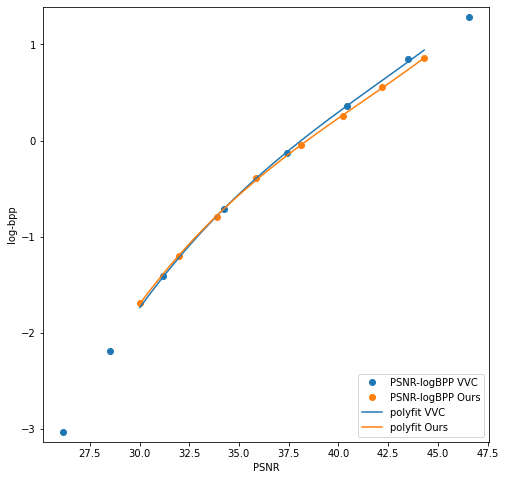

BD-rate = -2.9552215799999337


In [4]:
results_path = Path().cwd() / '../results/kodak-qres34m.json'
with open(results_path, 'r') as f:
    ours = json.load(f)

bd = bd_rate(
    vvc_results['results']['bpp'], vvc_results['results']['psnr'],
    ours['bpp'], ours['psnr'],
    name1='VVC', name2='Ours'
)
print(f'BD-rate = {bd}')
